In [251]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

In [252]:
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"

In [253]:
def best_progression_over_time(path: str, num_runs: int):
    results = []
    for run in range(num_runs):
        with open(path + f"run_{run}_data.pkl", "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = np.max(safe_obs_values)
        results.append(np.minimum.accumulate(safe_obs_values))
    results = np.array(results)
    results_mean = np.mean(results, axis=0)
    return results, results_mean

In [254]:
def best_progression_over_time_ignore_initial(path: str, num_runs: int):
    results = []
    for run in range(num_runs):
        with open(path + f"run_{run}_data.pkl", "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze()[-20:] <= 0
        inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze()[-20:] <= 0
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()[-20:]
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = np.max(safe_obs_values)
        results.append(np.minimum.accumulate(safe_obs_values))
    results = np.array(results)
    results_mean = np.mean(results, axis=0)
    return results, results_mean

In [255]:
def get_lambda_progression(path: str):
    with open(path, "rb") as fp:
        penalty_progression = pickle.load(fp)[INEQUALITY_CONSTRAINT_ONE]
        penalty_progression = np.array(penalty_progression).squeeze()
    return penalty_progression

In [256]:
five_hundred_initial_lambda_zero, five_hundred_initial_lambda_zero_mean = best_progression_over_time_ignore_initial("500_initial_samples_lambda_0/", 1)
five_hundred_initial_lambda_ten, five_hundred_initial_lambda_ten_mean = best_progression_over_time_ignore_initial("500_initial_samples_lambda_10/", 1)
five_hundred_initial_lambda_hundred, five_hundred_initial_lambda_hundred_mean = best_progression_over_time_ignore_initial("500_initial_samples_lambda_100/", 1)

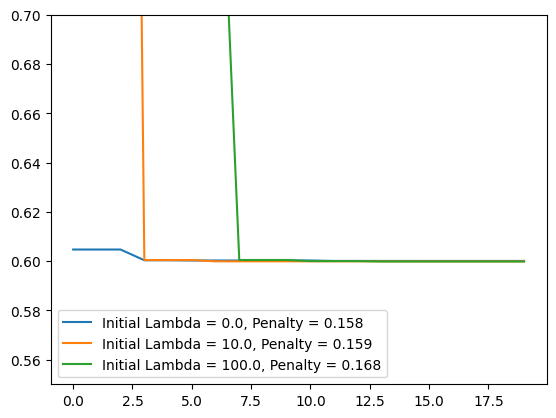

In [257]:
plt.plot(five_hundred_initial_lambda_zero_mean, label="Initial Lambda = 0.0, Penalty = 0.158")
plt.plot(five_hundred_initial_lambda_ten_mean, label="Initial Lambda = 10.0, Penalty = 0.159")
plt.plot(five_hundred_initial_lambda_hundred_mean, label="Initial Lambda = 100.0, Penalty = 0.168")
plt.ylim(0.55, 0.7)
plt.legend()
plt.show()

In [261]:
lambda_0_penalty_progression = get_lambda_progression("500_initial_samples_lambda_0/run_0_inequality_lambda_progression.pkl")
lambda_10_penalty_progression = get_lambda_progression("500_initial_samples_lambda_10/run_0_inequality_lambda_progression.pkl")
lambda_100_penalty_progression = get_lambda_progression("500_initial_samples_lambda_100/run_0_inequality_lambda_progression.pkl")

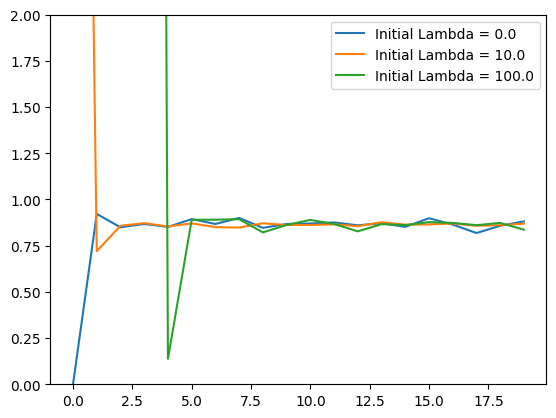

In [262]:
plt.plot(lambda_0_penalty_progression, label="Initial Lambda = 0.0")
plt.plot(lambda_10_penalty_progression, label="Initial Lambda = 10.0")
plt.plot(lambda_100_penalty_progression, label="Initial Lambda = 100.0")
plt.legend()
plt.ylim(0,2)
plt.show()

### Batch Size = 3, No Time Decay

In [263]:
all_inequality_lambda = []
for run in range(20):
    with open(f"../09-02-23/batch_3_automatic_penalty/run_{run}_inequality_lambda_progression.pkl", "rb") as fp:
        inequality_lambda = pickle.load(fp)[INEQUALITY_CONSTRAINT_ONE]
        all_inequality_lambda.append(inequality_lambda)
all_inequality_lambda = np.array(all_inequality_lambda).flatten()
print(f"Mean Inequality Lambda One: {np.mean(all_inequality_lambda)} STD: {np.std(all_inequality_lambda)}")
print(f"Num Where Above Ten: {np.sum(np.where(all_inequality_lambda > 10, 1, 0))}")
print(f"Num Where Below Two: {np.sum(np.where(all_inequality_lambda < 2, 1, 0))}")

Mean Inequality Lambda One: 48.056702742458256 STD: 270.61404862392436
Num Where Above Ten: 154
Num Where Below Two: 515


In [264]:
run = 7

with open(f"../09-02-23/batch_3_automatic_penalty/run_{run}_inequality_lambda_progression.pkl", "rb") as fp:
    inequality_lambda = pickle.load(fp)
a = tf.Variable(inequality_lambda[INEQUALITY_CONSTRAINT_ONE])
b = tf.transpose(tf.reshape(a, (14,3)))
x = np.arange(0, 42, 3)

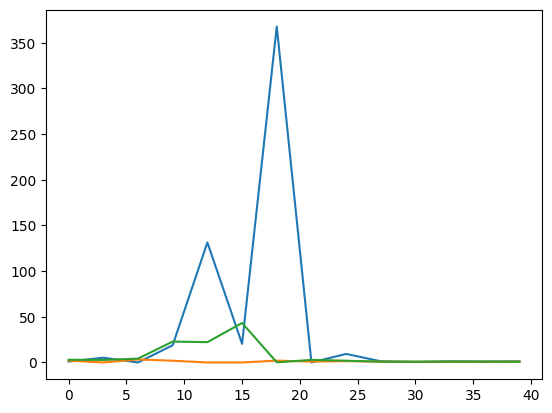

In [265]:
plt.plot(x, b[0])
plt.plot(x, b[1])
plt.plot(x, b[2])

### Batch Size = 3, Time Decay

In [266]:
all_inequality_lambda = []
for run in range(20):
    with open(f"../16-02-23/exponent_0.9/run_{run}_inequality_lambda_progression.pkl", "rb") as fp:
        inequality_lambda = pickle.load(fp)[INEQUALITY_CONSTRAINT_ONE]
        all_inequality_lambda.append(inequality_lambda)
all_inequality_lambda = np.array(all_inequality_lambda).flatten()
print(f"Mean Inequality Lambda One: {np.mean(all_inequality_lambda)} STD: {np.std(all_inequality_lambda)}")
print(f"Num Where Above Ten: {np.sum(np.where(all_inequality_lambda > 10, 1, 0))}")
print(f"Num Where Below Two: {np.sum(np.where(all_inequality_lambda < 2, 1, 0))}")

Mean Inequality Lambda One: 218.53095609214992 STD: 2814.916680332074
Num Where Above Ten: 184
Num Where Below Two: 464


In [309]:
# Run 3 and 8 are good
# Run 6 and 7 are bad
run = 6

with open(f"../16-02-23/exponent_0.9/run_{run}_inequality_lambda_progression.pkl", "rb") as fp:
    inequality_lambda = pickle.load(fp)
a = tf.Variable(inequality_lambda[INEQUALITY_CONSTRAINT_ONE])
b = tf.transpose(tf.reshape(a, (14,3)))
x = np.arange(0, 42, 3)

(0.0, 10.0)

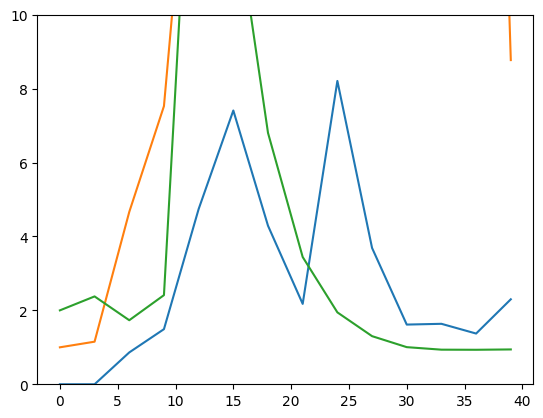

In [312]:
plt.plot(x, b[0])
plt.plot(x, b[1])
plt.plot(x, b[2])
plt.ylim(0,10)

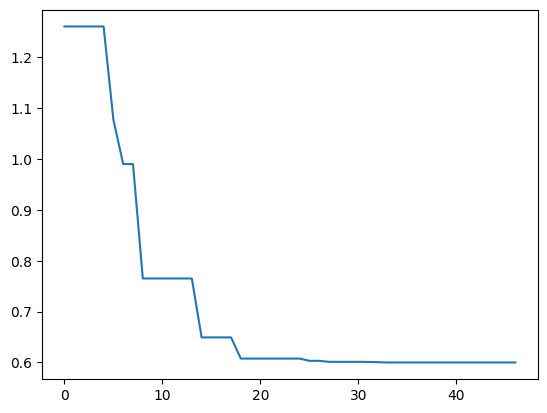

In [287]:
results = []
with open(f"../16-02-23/exponent_0.9/run_{run}_data.pkl", "rb") as fp:
    run_data = pickle.load(fp)
inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
failure_mask = np.logical_not(satisfied_mask)
objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
safe_obs_values = objective_vals.copy()
safe_obs_values[failure_mask] = np.max(safe_obs_values)
results.append(np.minimum.accumulate(safe_obs_values))
results = np.array(results)
results_mean = np.mean(results, axis=0)
plt.plot(results_mean)

### Batch Size = 3, Fixed Lambda for 15 Iterations

In [288]:
all_inequality_lambda = []
for run in range(20):
    with open(f"../16-02-23/fixed_accurate_lambda_first_15/run_{run}_inequality_lambda_progression.pkl", "rb") as fp:
        inequality_lambda = pickle.load(fp)[INEQUALITY_CONSTRAINT_ONE]
        all_inequality_lambda.append(inequality_lambda)
all_inequality_lambda = np.array(all_inequality_lambda).flatten()
print(f"Mean Inequality Lambda One: {np.mean(all_inequality_lambda)} STD: {np.std(all_inequality_lambda)}")
print(f"Num Where Above Ten: {np.sum(np.where(all_inequality_lambda > 10, 1, 0))}")
print(f"Num Where Below Two: {np.sum(np.where(all_inequality_lambda < 2, 1, 0))}")

Mean Inequality Lambda One: 339.8343988042463 STD: 4124.6312822229465
Num Where Above Ten: 79
Num Where Below Two: 576


In [303]:
# Good - 2, 3
run = 5

with open(f"../16-02-23/fixed_accurate_lambda_first_15/run_{run}_inequality_lambda_progression.pkl", "rb") as fp:
    inequality_lambda = pickle.load(fp)
a = tf.Variable(inequality_lambda[INEQUALITY_CONSTRAINT_ONE])
b = tf.transpose(tf.reshape(a, (14,3)))
x = np.arange(0, 42, 3)

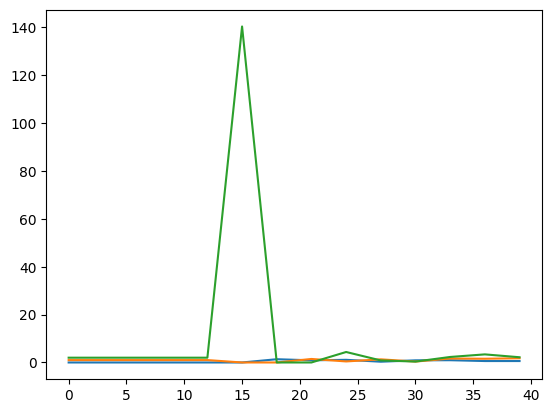

In [304]:
plt.plot(x, b[0])
plt.plot(x, b[1])
plt.plot(x, b[2])

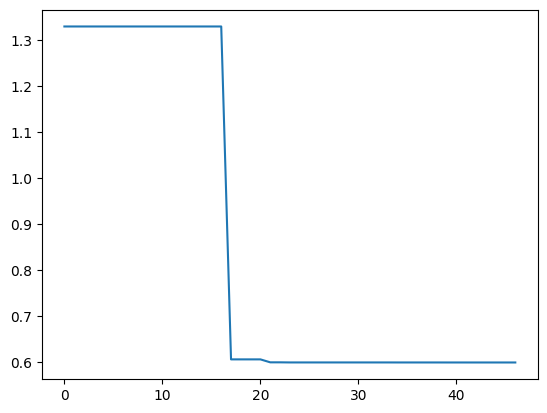

In [305]:
results = []
with open(f"../16-02-23/fixed_accurate_lambda_first_15/run_{run}_data.pkl", "rb") as fp:
    run_data = pickle.load(fp)
inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
failure_mask = np.logical_not(satisfied_mask)
objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
safe_obs_values = objective_vals.copy()
safe_obs_values[failure_mask] = np.max(safe_obs_values)
results.append(np.minimum.accumulate(safe_obs_values))
results = np.array(results)
results_mean = np.mean(results, axis=0)
plt.plot(results_mean)

### Convergence Comparison

In [306]:
_, no_time_decay_results_mean = best_progression_over_time("../09-02-23/batch_3_automatic_penalty/", 20)
_, time_decay_results_mean = best_progression_over_time("exponent_0.9/", 20)
_, fixed_start_results_mean = best_progression_over_time("fixed_lambda_first_15/", 20)
_, more_accurate_fixed_start_results_mean = best_progression_over_time("fixed_accurate_lambda_first_15/", 20)

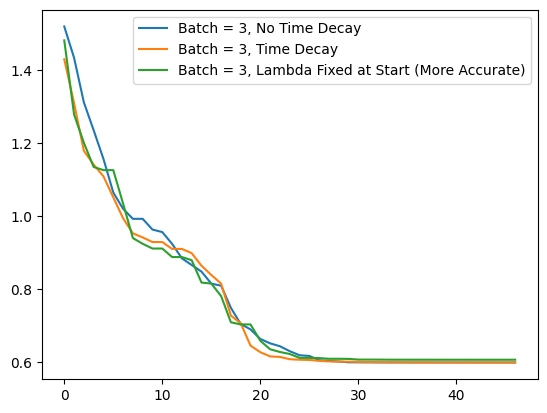

In [308]:
plt.plot(no_time_decay_results_mean, label="Batch = 3, No Time Decay")
plt.plot(time_decay_results_mean, label="Batch = 3, Time Decay")
plt.plot(more_accurate_fixed_start_results_mean, label="Batch = 3, Lambda Fixed at Start (More Accurate)")
plt.legend()